In [1]:
#!pip install yfinance

# Import libraries

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import shap
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings            
warnings.filterwarnings("ignore")

In [3]:
!pip install shap

# Data loading and exploration

In [4]:
# Download TSLA Data (10 years)
df = yf.download('TSLA', start='2014-01-01', end='2024-12-31')
df.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [5]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2014-01-02,10.006667,10.165333,9.770000,9.986667,92826000
2014-01-03,9.970667,10.146000,9.906667,10.000000,70425000
2014-01-06,9.800000,10.026667,9.682667,10.000000,80416500
2014-01-07,9.957333,10.026667,9.683333,9.841333,75511500
2014-01-08,10.085333,10.246667,9.917333,9.923333,92448000


In [6]:
df.shape

(2767, 5)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2767 entries, 2014-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, TSLA)   2767 non-null   float64
 1   (High, TSLA)    2767 non-null   float64
 2   (Low, TSLA)     2767 non-null   float64
 3   (Open, TSLA)    2767 non-null   float64
 4   (Volume, TSLA)  2767 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 129.7 KB


# Feature engineering

In [8]:
def add_indicators(data):
    data['MACD'] = data['Close'].ewm(span=12).mean() - data['Close'].ewm(span=26).mean()
    data['Signal_Line'] = data['MACD'].ewm(span=9).mean()

    delta = data['Close'].diff()
    gain = delta.copy()
    loss = delta.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    loss = loss.abs()
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))

    sma = data['Close'].rolling(window=20).mean()
    std = data['Close'].rolling(window=20).std()
    data['Upper_BB'] = sma + 2 * std
    data['Lower_BB'] = sma - 2 * std

    data['Momentum'] = data['Close'] - data['Close'].shift(10)

    low_min = data['Low'].rolling(window=14).min()
    high_max = data['High'].rolling(window=14).max()
    data['Stochastic'] = 100 * ((data['Close'] - low_min) / (high_max - low_min))

    data['Volume_Change'] = data['Volume'].pct_change() * 100

    return data.dropna()

In [9]:
df = add_indicators(df)

In [10]:
# Label next-day movement
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

In [11]:
# Drop NA values after indicators
df.dropna(inplace=True)

In [12]:
df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]
# Show updated column names
print(df.columns)

Index(['Close_TSLA', 'High_TSLA', 'Low_TSLA', 'Open_TSLA', 'Volume_TSLA',
       'MACD_', 'Signal_Line_', 'RSI_', 'Upper_BB_', 'Lower_BB_', 'Momentum_',
       'Stochastic_', 'Volume_Change_', 'Target_'],
      dtype='object')


# Data Visualisation

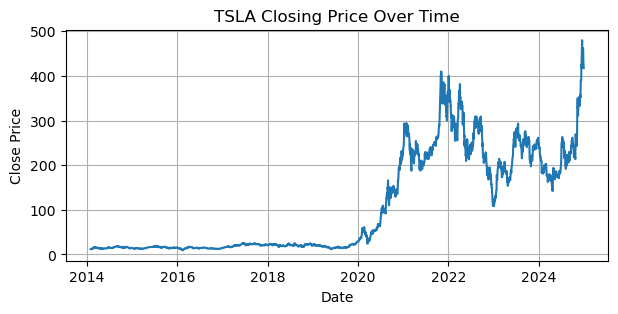

In [13]:
# Closing Price Trend Over Time
plt.figure(figsize=(7,3))
sns.lineplot(data=df, x=df.index, y='Close_TSLA')
plt.title("TSLA Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

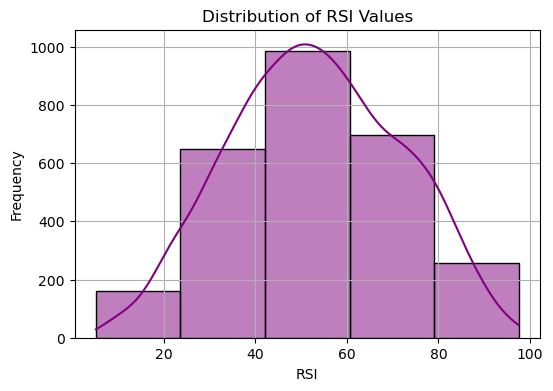

In [14]:
# Histogram of RSI (Relative Strength Index)
plt.figure(figsize=(6,4))
sns.histplot(df['RSI_'], bins=5, kde=True, color='purple')
plt.title("Distribution of RSI Values")
plt.xlabel("RSI")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

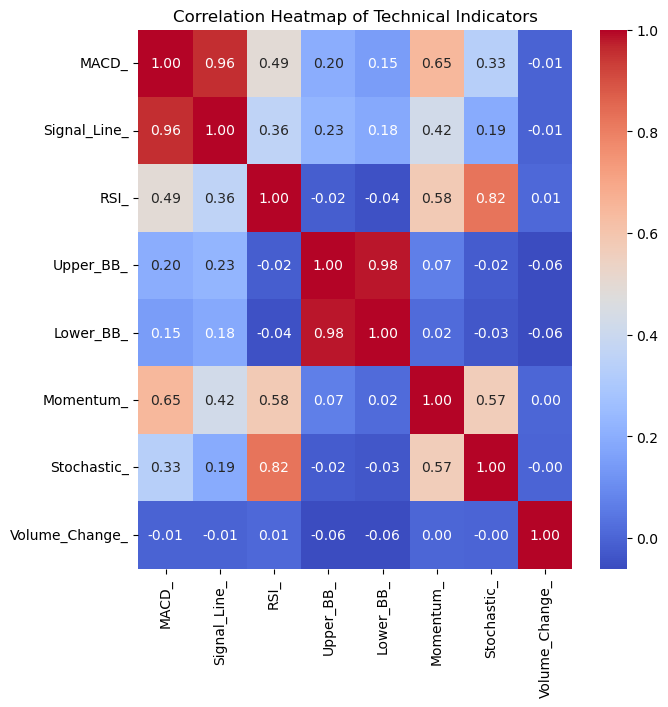

In [15]:
#Correlation Heatmap of Features
features = ['MACD_', 'Signal_Line_', 'RSI_', 'Upper_BB_', 'Lower_BB_', 'Momentum_',
       'Stochastic_', 'Volume_Change_']
plt.figure(figsize=(7,7))
sns.heatmap(df[features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Technical Indicators")
plt.show()

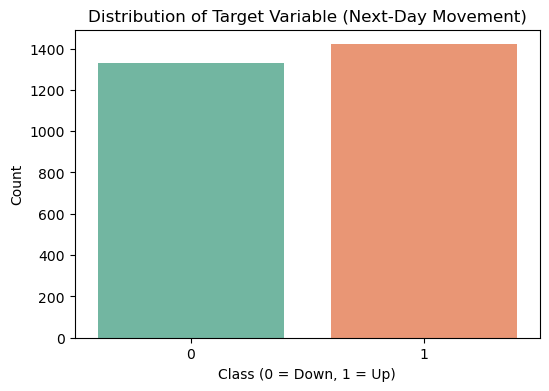

In [16]:
# Bar Plot of Class Distribution (Target)
plt.figure(figsize=(6,4))
sns.countplot(x=df['Target_'], palette='Set2')
plt.title("Distribution of Target Variable (Next-Day Movement)")
plt.xlabel("Class (0 = Down, 1 = Up)")
plt.ylabel("Count")
plt.show()

# Feature selection and Splitting

In [17]:
# Feature selection
X = df[features]
y = df['Target_']

In [18]:
# 5. Train/Test Split (chronological split to avoid leakage)
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [19]:
# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# Balance the training data
sm = SMOTE(random_state=42)
X_train_scaled, y_train = sm.fit_resample(X_train_scaled, y_train)

# Machine learning Model

In [21]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='accuracy')

In [22]:
grid_rf.fit(X_train_scaled, y_train)
best_rf = grid_rf.best_estimator_

In [23]:
print(best_rf)

RandomForestClassifier(n_estimators=200, random_state=42)


In [24]:
rf_preds = best_rf.predict(X_test_scaled)
print("Random Forest:\n", classification_report(y_test, rf_preds))

Random Forest:
               precision    recall  f1-score   support

           0       0.48      0.27      0.35       267
           1       0.51      0.72      0.60       283

    accuracy                           0.50       550
   macro avg       0.50      0.50      0.47       550
weighted avg       0.50      0.50      0.48       550



In [25]:
rf_probs = best_rf.predict_proba(X_test_scaled)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, rf_probs))

ROC-AUC: 0.5001588120855996


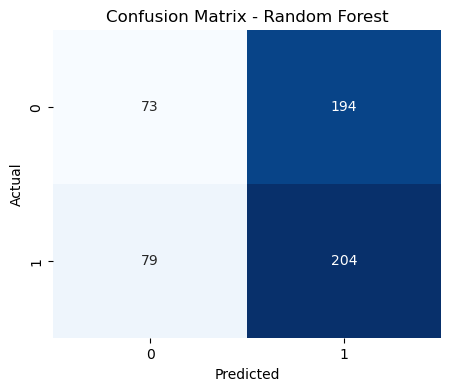

In [26]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

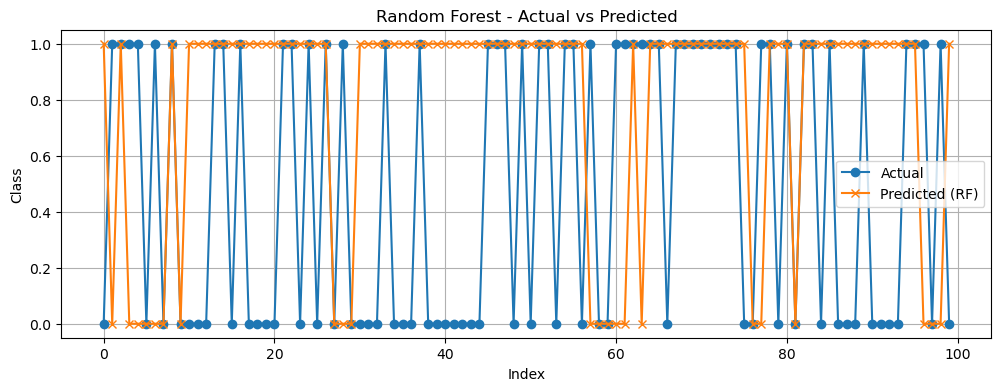

In [27]:
plt.figure(figsize=(12, 4))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(rf_preds[:100], label='Predicted (RF)', marker='x')
plt.title('Random Forest - Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Class')
plt.legend()
plt.grid(True)
plt.show()

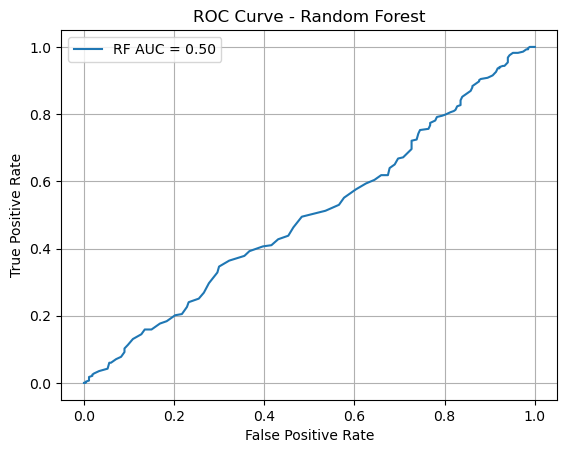

In [28]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, rf_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"RF AUC = {roc_auc_score(y_test, rf_probs):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

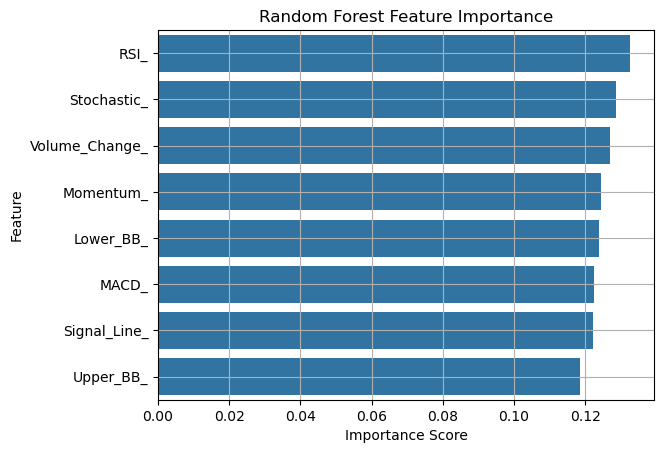

In [29]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot Feature Importance
plt.figure()
sns.barplot(x=importances[indices], y=np.array(features)[indices])
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

In [30]:
# Create SHAP explainer
explainer = shap.TreeExplainer(best_rf)

In [31]:
# Compute SHAP values (list of arrays: one per class)
shap_values = explainer.shap_values(X_test_scaled)

In [32]:
len(shap_values)

550

In [33]:
X_test_scaled.shape

(550, 8)

In [34]:
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

In [35]:
X_test_df.shape

(550, 8)

In [36]:
# Pick class index
class_index = 1 

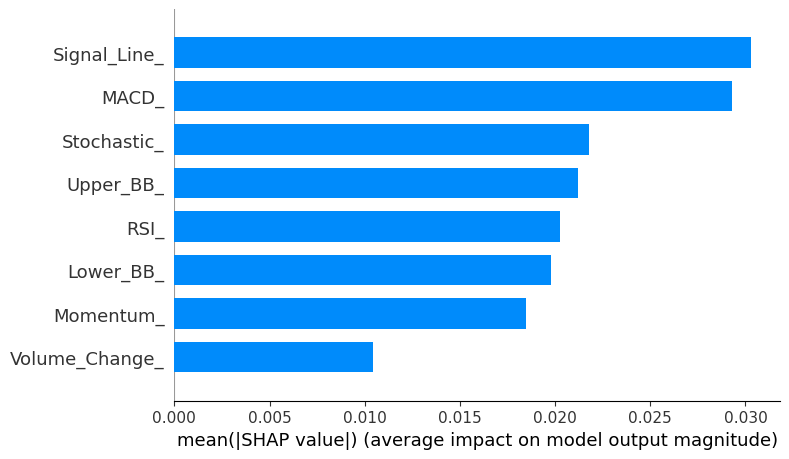

In [37]:
shap.summary_plot(shap_values[:, :, class_index], X_test_df, plot_type="bar", show=True)

In [38]:
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [39]:
xgb_preds = xgb.predict(X_test_scaled)

In [40]:
print("XGBoost Performance:\n", classification_report(y_test, xgb_preds))

XGBoost Performance:
               precision    recall  f1-score   support

           0       0.49      0.38      0.43       267
           1       0.52      0.63      0.57       283

    accuracy                           0.51       550
   macro avg       0.50      0.50      0.50       550
weighted avg       0.50      0.51      0.50       550



In [41]:
xgb_probs = xgb.predict_proba(X_test_scaled)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, xgb_probs))

ROC-AUC: 0.4919866068474477


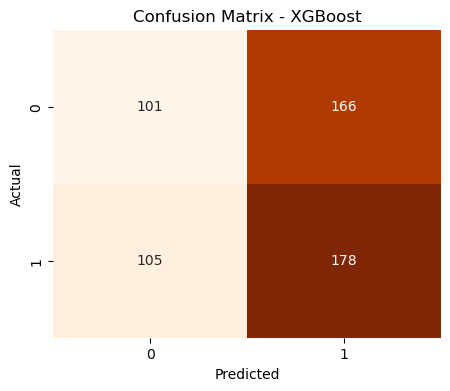

In [42]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

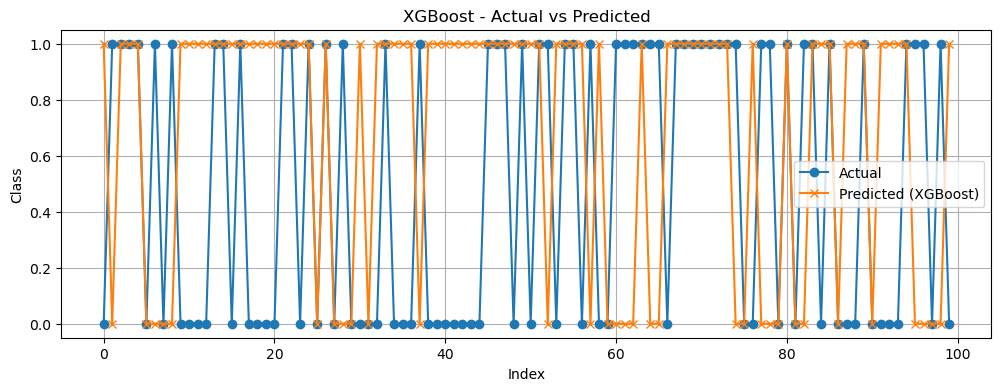

In [43]:
plt.figure(figsize=(12, 4))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(xgb_preds[:100], label='Predicted (XGBoost)', marker='x')
plt.title('XGBoost - Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Class')
plt.legend()
plt.grid(True)
plt.show()

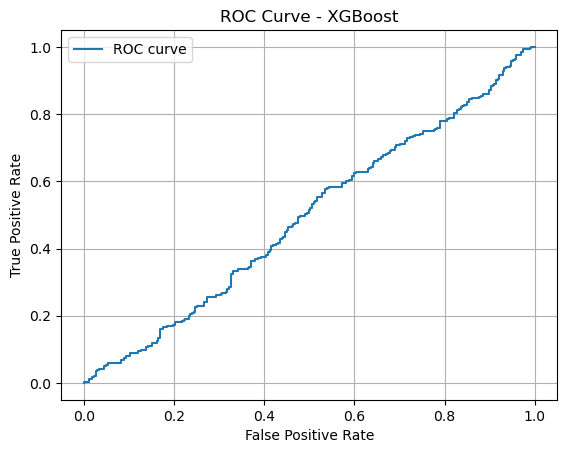

In [44]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, xgb_probs)
plt.figure()
plt.plot(fpr, tpr, label="ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.grid(True)
plt.show()

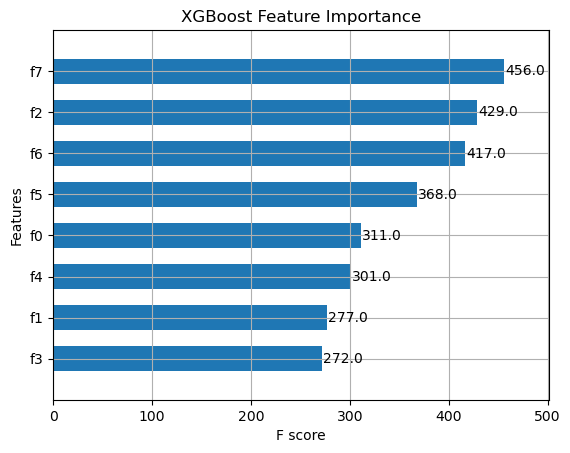

In [45]:
# Feature Importance - XGBoost
plot_importance(xgb, height=0.6)
plt.title("XGBoost Feature Importance")
plt.show()

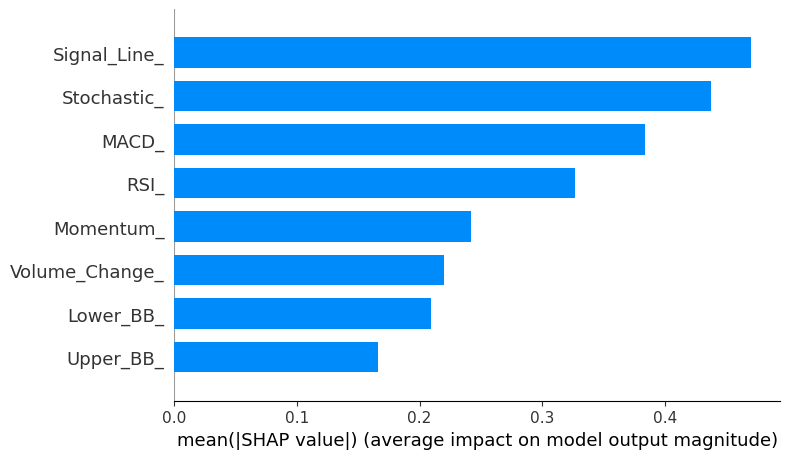

In [46]:
# SHAP values - XGBoost
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test_df, plot_type="bar", show=True)

In [47]:
# Baseline model
baseline_preds = y_test.shift(1).fillna(method='bfill')
baseline_acc = (baseline_preds == y_test).mean()
print(f"Baseline Accuracy (predict same as yesterday): {baseline_acc:.2f}")

Baseline Accuracy (predict same as yesterday): 0.51


In [48]:
# LSTM Model
def create_lstm_dataset(X, y, window=10):
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i-window:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

In [49]:
# Time-aware split
split = int(0.8 * len(df))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [50]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [51]:
smote = SMOTE(random_state=42)
X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)

In [52]:
full_X = np.vstack((X_train_scaled, X_test_scaled))
full_y = np.hstack((y_train, y_test))
X_lstm, y_lstm = create_lstm_dataset(full_X, full_y, window=10)
X_train_lstm, X_test_lstm = X_lstm[:split-10], X_lstm[split-10:]
y_train_lstm, y_test_lstm = y_lstm[:split-10], y_lstm[split-10:]

In [53]:
lstm = Sequential()
lstm.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm.add(Dropout(0.2))
lstm.add(Dense(1, activation='sigmoid'))
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [54]:
lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,753 (73.25 KB)

 Trainable params: 18,753 (73.25 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
lstm.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5069 - loss: 0.6972
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5204 - loss: 0.6927
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4870 - loss: 0.6936
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5311 - loss: 0.6889
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5117 - loss: 0.6901
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5245 - loss: 0.6924
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5352 - loss: 0.6869
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5326 - loss: 0.6931
Epoch 9/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5316 - loss: 0.6939
Epoch 10/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5309 - loss: 0.6870


In [56]:
lstm_preds = (lstm.predict(X_test_lstm) > 0.5).astype(int)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [57]:
print("LSTM Performance:\n", classification_report(y_test_lstm, lstm_preds))

LSTM Performance:
               precision    recall  f1-score   support

           0       0.62      0.34      0.44       343
           1       0.48      0.74      0.58       283

    accuracy                           0.52       626
   macro avg       0.55      0.54      0.51       626
weighted avg       0.56      0.52      0.50       626



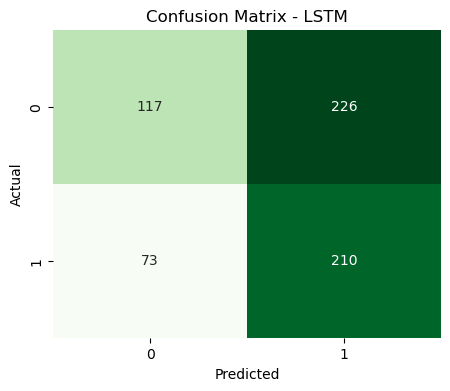

In [58]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test_lstm, lstm_preds), annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title("Confusion Matrix - LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

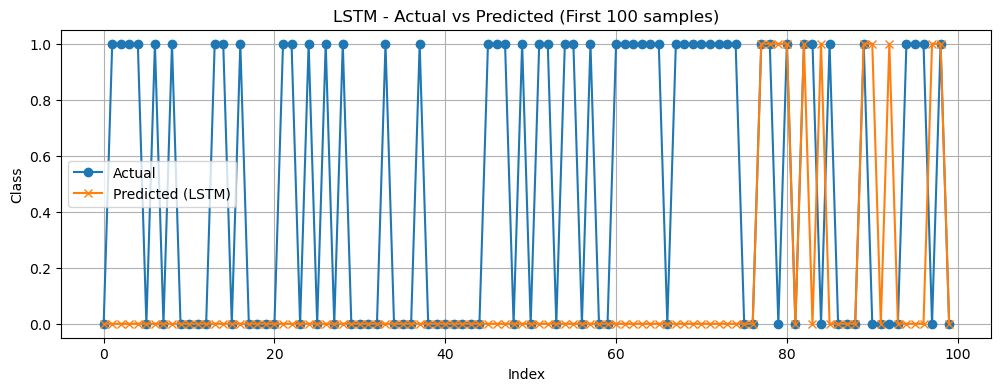

In [59]:
plt.figure(figsize=(12, 4))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(y_test_lstm[:100], label='Predicted (LSTM)', marker='x')
plt.title('LSTM - Actual vs Predicted (First 100 samples)')
plt.xlabel('Index')
plt.ylabel('Class')
plt.legend()
plt.grid(True)
plt.show()

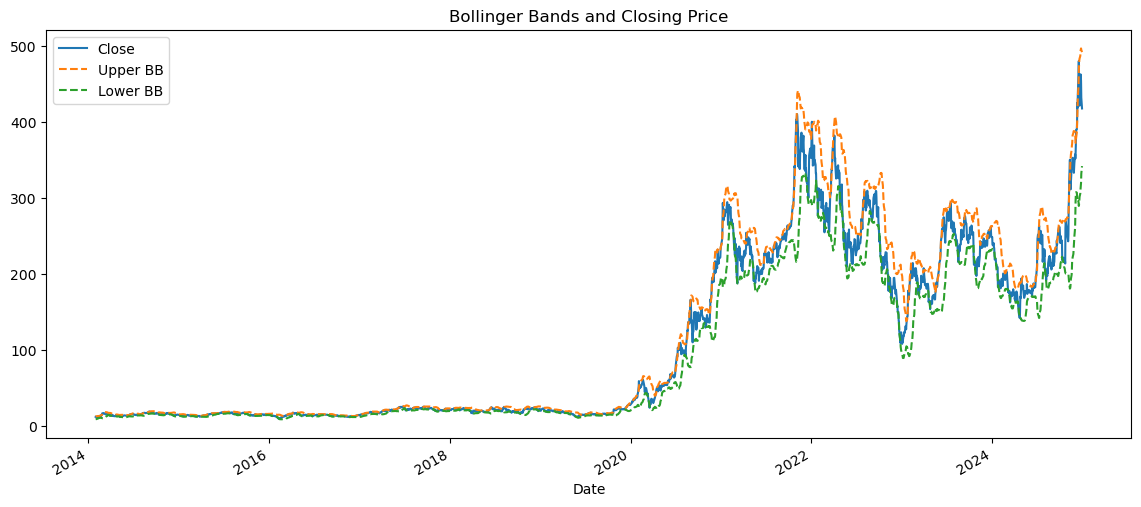

In [60]:
# Plot Sample Indicators
plt.figure(figsize=(14, 6))
df['Close_TSLA'].plot(label='Close')
df['Upper_BB_'].plot(label='Upper BB', linestyle='--')
df['Lower_BB_'].plot(label='Lower BB', linestyle='--')
plt.legend()
plt.title("Bollinger Bands and Closing Price")
plt.show()

# Backtesting Strategy

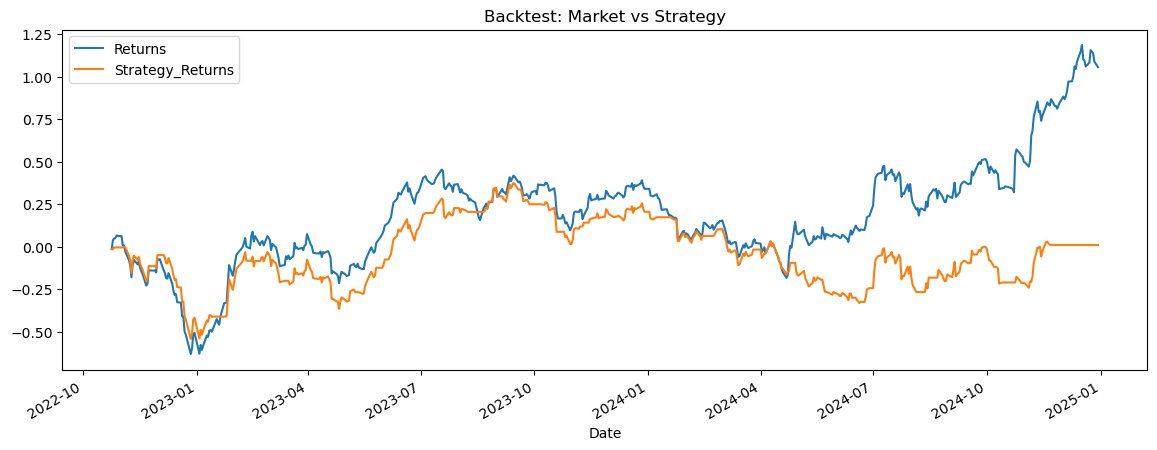

In [61]:
# Backtesting Strategy (basic simulation)
df_test = df.iloc[train_size:].copy()
df_test['Pred_RF'] = rf_preds
df_test['Returns'] = df_test['Close_TSLA'].pct_change()
df_test['Strategy_Returns'] = df_test['Returns'] * df_test['Pred_RF'].shift(1)
df_test[['Returns', 'Strategy_Returns']].cumsum().plot(figsize=(14,5), title='Backtest: Market vs Strategy')
plt.show()